In [1]:
import nest
import pylab
import numpy

In [28]:

# Excitatory synaptic elements of excitatory neurons
growth_curve_e_e = {
    'growth_curve': "gaussian",
    'growth_rate': 0.0001,  # (elements/ms)
    'continuous': False,
    'eta': 0.0,  # Ca2+
    'eps': 0.2,  # Ca2+
}

# Inhibitory synaptic elements of excitatory neurons
growth_curve_e_i = {
    'growth_curve': "gaussian",
    'growth_rate': 0.0001,  # (elements/ms)
    'continuous': False,
    'eta': 0.0,  # Ca2+
    'eps': growth_curve_e_e['eps'],  # Ca2+
}

# Excitatory synaptic elements of inhibitory neurons
growth_curve_i_e = {
    'growth_curve': "gaussian",
    'growth_rate': 0.0004,  # (elements/ms)
    'continuous': False,
    'eta': 0.0,  # Ca2+
    'eps': 0.1,  # Ca2+
}

# Inhibitory synaptic elements of inhibitory neurons
growth_curve_i_i = {
    'growth_curve': "gaussian",
    'growth_rate': 0.0001,  # (elements/ms)
    'continuous': False,
    'eta': 0.0,  # Ca2+
    'eps': growth_curve_i_e['eps']  # Ca2+
}

synaptic_elements = {
    'Den_ex': growth_curve_e_e,
    'Den_in': growth_curve_e_i,
    'Axon_ex': growth_curve_e_e,
}

synaptic_elements_i = {
    'Den_ex': growth_curve_i_e,
    'Den_in': growth_curve_i_i,
    'Axon_in': growth_curve_i_i,
}

neuron_params_thl = {
        #'model' : "aeif_cond_exp",
        'E_L': -60.,  # resting membrane potential (mV) - see refs
        'V_m' : -60,
        'C_m': 50.0,      # membrane capacity (pF)
        'g_L': 5.0,      # leak conductance  - see refs
        'V_reset': -52.,  # reset membrane potential after a spike (mV)  - for bustiness
        'V_th': -50.,  # spike threshold (mV)
        'tau_syn_ex': 2.5, # exc. synaptic time constant  - mit paper
        'tau_syn_in': 10., # exc. synaptic time constant  - mit paper

        # initial burst + adaptation
        "a": 0.5,
        "b": 10.,
        'tau_w': 150.,
    }

neuron_params_aone = {
        #'model': 'aeif_cond_exp',
        'E_L': -70.,  # resting membrane potential (mV)
        'C_m': 150.0,  # membrane capacity (pF)
        'g_L': 10.0,  # leak conductance  - in combo with C_m you get tau_m = ~15 ms
        'V_reset': -60.,  # reset membrane potential after a spike (mV)
        'V_th': -55.,  # spike threshold (mV)
        'tau_syn_ex': 5.,  # exc. synaptic time constant
        'tau_syn_in': 10.,  # exc. synaptic time constant

        # initial burst + adaptation
        "a": 2.,
        "b": 60.,
        'tau_w': 200.,
    }

In [29]:
nest.ResetKernel()
nest.EnableStructuralPlasticity()

nest.CopyModel('static_synapse', 'synapse_ex')
nest.SetDefaults('synapse_ex', {'weight': 1., 'delay': 0.1})
nest.CopyModel('static_synapse', 'synapse_in')
nest.SetDefaults('synapse_in', {'weight': -1., 'delay': 0.1})
nest.structural_plasticity_synapses = {
        'synapse_ex': {
            'synapse_model': 'synapse_ex',
            'post_synaptic_element': 'Den_ex',
            'pre_synaptic_element': 'Axon_ex'
        },
        'synapse_in': {
            'synapse_model': 'synapse_in',
            'post_synaptic_element': 'Den_in',
            'pre_synaptic_element': 'Axon_in'
        }
    }

noise = nest.Create('poisson_generator', n=1)
noise.rate = 10

n1 = nest.Create("aeif_cond_exp", 200, {'synaptic_elements': synaptic_elements})
nest.SetStatus(n1, neuron_params_aone)

n2 = nest.Create("aeif_cond_exp", 50, {'synaptic_elements': synaptic_elements_i})
nest.SetStatus(n2, neuron_params_aone)

#v = nest.Create("voltmeter")
sr1 = nest.Create("spike_recorder")
sr2 = nest.Create("spike_recorder")

#nest.Connect(n1, n2)

nest.Connect(n1, sr1)
nest.Connect(n2, sr2)

'''sg = nest.Create('spike_generator')

nest.SetStatus(sg, {'spike_times' : [10., 20., 130., 140.]})

nest.Connect(sg, n, syn_spec={'weight':.1})'''

nest.Connect(noise, n1, syn_spec={'weight':15.})
nest.Connect(noise, n2, syn_spec={'weight':25.})

step = 100
simtime = 100. * 1e3
#for _ in range(0, simtime, step):
nest.Simulate(simtime)

In [24]:
# import matplotlib.pyplot as plt
# plt.hist(sr1.get("events")['times'])

In [30]:
print("Ca Levels: ", numpy.mean(n1.Ca), numpy.mean(n2.Ca))
print("Mean Spiking Activity Exc: ", (len(sr1.get("events")['times']) / simtime * 1e3) / 200)
print("Mean Spiking Activity Inh: ", (len(sr2.get("events")['times']) / simtime * 1e3) / 50)
'''
[print(_['Den_ex']['z_connected'], \
      _['Den_in']['z_connected'], _['Axon_ex']['z_connected']) for _ in n1.synaptic_elements];
[print(_['Den_ex']['z_connected'], \
      _['Den_in']['z_connected'], _['Axon_in']['z_connected']) for _ in n2.synaptic_elements];
'''

print("Exc Neuron Axonal Connections: ", numpy.mean([_['Axon_ex']['z_connected'] for _ in n1.synaptic_elements]))
print("Inh Neuron Axonal Connections: ", numpy.mean([_['Axon_in']['z_connected'] for _ in n2.synaptic_elements]))

print("Exc Neuron Z: ", numpy.mean([_['Axon_ex']['z'] for _ in n1.synaptic_elements]))
print("Inh Neuron Z: ", numpy.mean([_['Axon_in']['z'] for _ in n2.synaptic_elements]))


Ca Levels:  0.0337645650594962 0.09883247278763582
Mean Spiking Activity Exc:  3.31765
Mean Spiking Activity Inh:  9.841600000000001
Exc Neuron Axonal Connections:  3.075
Inh Neuron Axonal Connections:  1.6
Exc Neuron Z:  4.200357642618717
Inh Neuron Z:  2.1507314713062646


estimated firing rate in Hz:  9.950045756403817
estimated ca:  0.09950045756404097


Text(0, 0.5, 'Ca2+ levels')

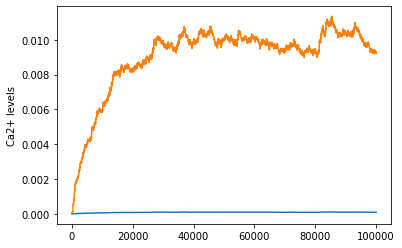

In [38]:
import numpy as np
from scipy import signal, integrate
from matplotlib import pyplot as plt

t_sim_s = 100   # in s
t_sim_ms = t_sim_s * 1e3  # in ms

tau = 10000  # time constant of the exponential (kernel), in ms. In NEST it's 10s by default, so 10000
fr = 10  # n spikes / sec (~firing rate, just the number of spikes here) -- it's the value we should get back in the end approx
spk = np.random.randint(5, t_sim_ms, fr * t_sim_s)  # draw #spike times corresponding to given fr
len_sig = tau * 100  # needed for convolution
t_ca = np.zeros(len_sig)  # time axis for convolution, will put the spikes on this
t_fr = np.zeros(len_sig)  # time axis for convolution, will put the spikes on this

beta = 0.000001 # beta from equation - increase in Ca levels for each spike

t_ca[spk] = 1 * beta  # set the spikes on the time axis, scaled by beta - for the Calcium signal, as per equation
t_fr[spk] = 1 / tau  # set the spikes on the time axis, scaled by tau - this will give you a FR estimate in Hz

exp = signal.exponential(tau * 10, center=0, tau=tau, sym=False)  # create exp kernel, make the window 10x tau so it's large enough for precision
ca_sig = signal.convolve(exp, t_ca)  # this is the Ca level / signal, as per the equation
fr_sig = signal.convolve(exp, t_fr)  # this is the instantaneous firing rate, i.e., the spike convolved by exp kernel

# by integrating over 1 s (here full signal) we can estimate the mean FR rate
integral = integrate.cumtrapz(fr_sig, np.arange(len(fr_sig)), initial=0)
est_fr_hz = integral[-1] / t_sim_s  # get the mean of integral over 1 sec => for rate in Hz

print("estimated firing rate in Hz: ", est_fr_hz)

# by integrating over 1 s (here full signal) we can estimate the mean FR rate
integral = integrate.cumtrapz(ca_sig, np.arange(len(fr_sig)), initial=0)
est_fr_hz = integral[-1] / t_sim_s  # get the mean of integral over 1 sec => for rate in Hz

print("estimated ca: ", est_fr_hz)

plt.plot(ca_sig[:int(t_sim_ms)])  # Ca2+ levels
plt.plot(fr_sig[:int(t_sim_ms)])  # Ca2+ levels
plt.ylabel('Ca2+ levels')

## Structural Plasticity Implementation Equation
#### Diaz-Pier 2016

In [29]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

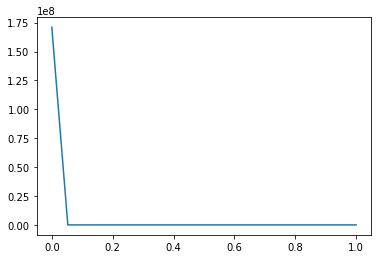

In [94]:
nu = 0.0001 # growth rate
eta = 0.16 # minumum Ca to build connections
epsilon = 17 / 100. # max Ca to reach
xi = (eta+epsilon)/2
zeta = (epsilon-eta)/(2 * np.power(np.log(2), 0.5))

ca = np.linspace(0, 1., 20)

dz_by_dt = nu * (2 * np.exp(-1 * (ca - xi) / zeta ) -1)

plt.plot(ca, dz_by_dt)

In [69]:
dz_by_dt_linear = nu * (1 - (ca / epsilon))

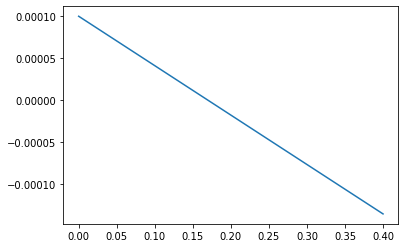

In [72]:
plt.plot(ca, dz_by_dt_linear)

In [59]:
nu_ = np.array([0.01, 0.001, 0.0001, 0.00001]) # growth rate
eta_ = np.linspace(0., 1., 10) # minumum Ca to build connections
epsilon_ = np.linspace(0.05, 1., 10) # max Ca to reach

nu, eta, epsilon = np.meshgrid(nu_, eta_, epsilon_, indexing='ij')

# df = pd.DataFrame(
#     {
#         "nu" : nu,
#         "eta" : eta,
#         "epsilon" : epsilon,
#         "ca" : ca
#     }
# )

# df['xi'] = (df.eta + df.epsilon)/2

# df['zeta'] = (df.epsilon - df.eta)/(2 * np.power(np.log(2), 0.5))

# df['dz_by_dt'] = df.nu * (2 * np.exp(-1 * (df.ca - df.xi) / df.zeta ) -1)